# Manufacturing Inspection
In this assignment you will apply simple image processing techniques to determine the level of liquid in a bottle.
You will follow a series of steps/functions to implement an algorithm that can find and mark the fluid levels in a bottle.

![link text](https://github.com/tonyscan6003/etivities/blob/main/manu_inspect.JPG?raw=true)








#Housekeeping:
Import packages, read test image, define helper functions.

In [1]:
import numpy as np
from skimage import feature
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request
import os
from urllib.parse import urlparse

In [2]:
# function to read images from Web addresses.
# function to read images from Web addresses.
def download_image(url, save_path):
    """
    Downloads an image from a URL and saves it to disk.
    If the image already exists at the specified path, it is read from disk.

    Args:
        url (str): URL of the image.
        save_path (str): Path to save the image on disk.

    Returns:
        None
    """
    # Parse the URL to get the filename
    filename = os.path.basename(urlparse(url).path)
    image_path = os.path.join(save_path, filename)

    # Check if the image already exists
    if os.path.exists(image_path):
        print(f"Image already exists at {image_path}. Reading from disk.")
        image = cv2.imread(image_path)
    else:
        print(f"Downloading image from {url}...")
        resp = urllib.request.urlopen(url)
        temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
        temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        print(f"Image downloaded and saved at {image_path}.")
        cv2.imwrite(image_path, temp_image)
        image = cv2.imread(image_path)
    return image

# Function to normalise images for display
def norm_img(ip_img):
   norm_img = ip_img-np.min(ip_img)
   norm_img = norm_img/(np.max(ip_img)-np.min(ip_img))
   return norm_img

Image downloaded and saved at ./NEW_Fill_level_Rounded_Image_660pxh.jpg.


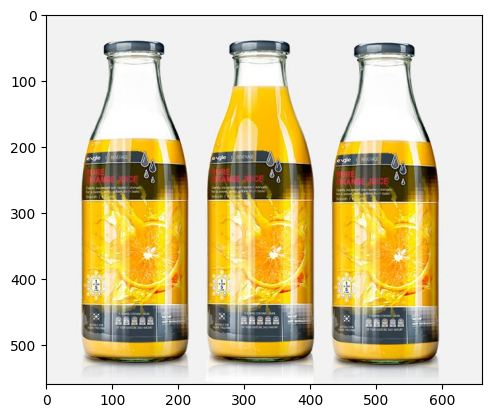

In [3]:
# read in test image
image_url = "https://cdn.eaglepi.com/uploads/2016/08/NEW_Fill_level_Rounded_Image_660pxh.jpg"

image = download_image(image_url,save_path="./")
plt.imshow(image)
# Convert to greyscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Methodology

In the code cells below we will apply a sequence of image processing techniques to find the fluid levels of the bottles.

1. Threshold the image and apply a closing operation.
2. Apply the Canny Algorithm to find edges.
3. Use a mask on region of interest (where fluid levels are)
4. Use the Hough algorithm to find lines corresponding to edges.
5. Find the horizontal lines corresponding to fluid levels and mark on the image.




## 1. Threshold & Morphology
Complete the function `apply_threshold_and_closing` in the code cell below.
 * This function will apply the [OpenCV2 Threshold](https://docs.opencv.org/4.5.1/d7/d4d/tutorial_py_thresholding.html) operation to the input grayscale image producing a binary image of the bottles. (Note that it is better to use the CV.THRESH_BINARY_INV option as this makes the bottle edge white and the fluid black after the threshold operation)
 * The [OpenCV2 closing operation](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html) is then used to make to help remove some of the holes in the image and noise around the edges.

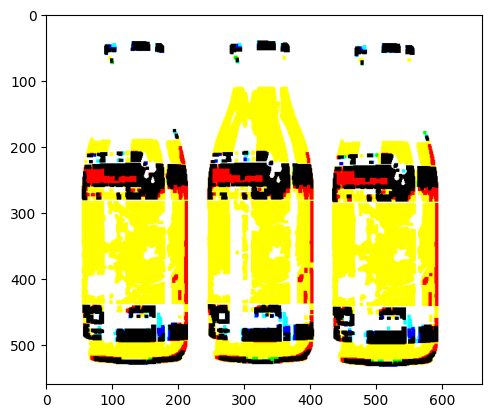

In [4]:
def apply_threshold_and_closing(image, threshold_value=128, kernel_size=5):
    """
    Applies thresholding and closing morphology operation to an image.

    Args:
        image (2d numpy array): Input image.
        threshold_value (int): Threshold value for binarization (default: 128).
        kernel_size (int): Size of the kernel for closing operation (default: 5).

    Returns:
        tuple: A tuple containing the thresholded image, the closed image
    """

    # Apply thresholding and closing morphology operation to the image.
    _, thresholded = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    # Define a kernel for closing operation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply closing morphology operation
    closed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)


    # Return the thresholded and closed images
    return thresholded, closed

# Example usage
thresholded_image, closed_image = apply_threshold_and_closing(image)
plt.imshow(thresholded_image)
plt.imshow(closed_image)
plt.show()

You can test if the function behaves correctly in the code cell below.

(-0.5, 659.5, 559.5, -0.5)

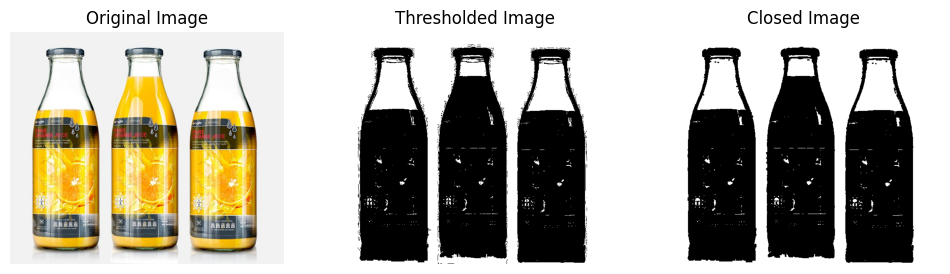

In [5]:
# Call the function
thresholded, closed = apply_threshold_and_closing(gray, threshold_value=240, kernel_size=3)

# Create a plot with 3 subplots to display images
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')
axs[1].imshow(thresholded, cmap='gray')
axs[1].set_title("Thresholded Image")
axs[1].axis('off')
axs[2].imshow(closed, cmap='gray')
axs[2].set_title("Closed Image")
axs[2].axis('off')

## 2. Canny Edge Detection.
The OpenCV implementation of the [Canny Algorithm](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html) can be used to find edges in binary images of the bottles we have just produced. Complete the function `apply_canny`in code cell below and check your result.



In [6]:
import cv2

def apply_canny(image, low_threshold, high_threshold):
    """
    Applies the Canny edge detection algorithm to an image.

    Inputs:
    - image (numpy array): Input Image.
    - low_threshold (int): The lower threshold for the hysteresis procedure in Canny edge detection.
    - high_threshold (int): The higher threshold for the hysteresis procedure in Canny edge detection.

    Outputs:
    - edges: An image (numpy array) with edges detected using the Canny algorithm.
    """

    # Apply Canny edge detection
    edges = cv2.Canny(image, low_threshold, high_threshold)
    # Return the image with edges
    return edges


Test the operation of the function apply_canny
* The input image to your function should be the "closed" image produced by the thresholding and morphology step.


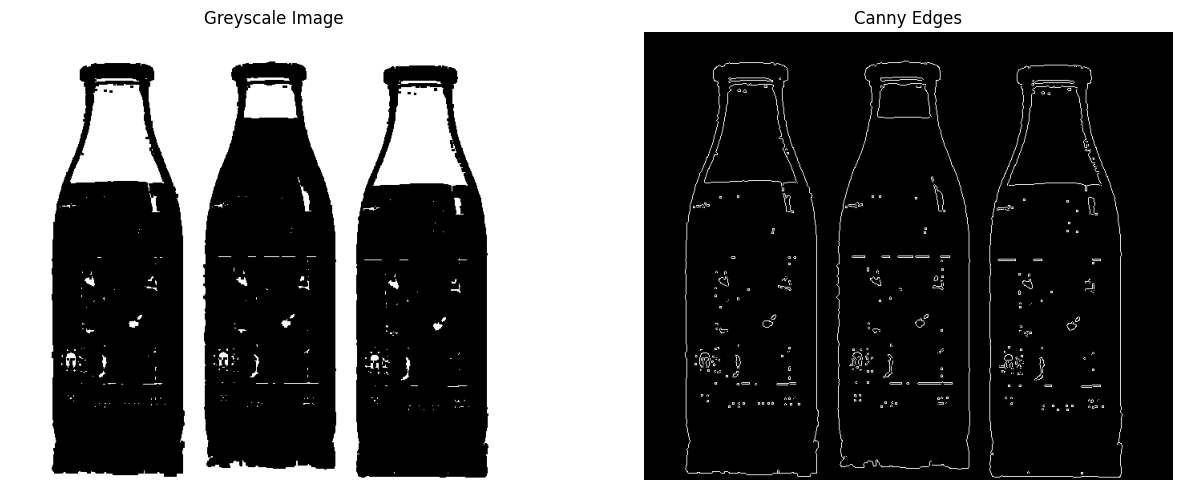

In [7]:
# Call function
low_threshold = 0
high_threshold = 50
canny_edges = apply_canny(closed, low_threshold, high_threshold)

# Plot results
def plot_img2(ip_imgs,labels):
   f, axarr = plt.subplots(1,2,figsize=(15,11))
   axarr[0].imshow(ip_imgs[0],'gray')
   axarr[0].title.set_text('Greyscale Image')
   axarr[0].axis('off')
   axarr[1].imshow((ip_imgs[1]),'gray')
   axarr[1].title.set_text(labels[0])
   axarr[1].axis('off')

labels = ['Canny Edges']
plot_img2([closed,canny_edges],labels)



## 3. Create Mask for Region of Interest.

We use a mask to select a region of interest around the fluid levels. The part of the image inside the region is retained and the rest of the image is removed (set to zero). This masking process is useful as it allows us to remove horizonatal edges due to the bottle cap or bottle base that could be confused with the fluid level.

You will complete the function `mask_img` below. This function will create a binary Mask for the Region of Interest.
* Initally define a blank mask the same size as the input image. (The numpy function [zeros_like](https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html) is a quick way to do this.)
* The region of interest (white pixels) can be added to the mask using the cv2.fillPoly method that can create a a filled rectangular region.
 * The shape of the region is determined by the number of vertices applied to the cv2.fillPoly method. If a rectangle is required then 4 vertices are needed. (we create the vertices in the next code cell)

* Finally to apply the mask to the binary image the [cv2.bitwise_and](https://docs.opencv.org/4.x/d0/d86/tutorial_py_image_arithmetics.html) method can be used.


In [8]:
"""
# In order to create a rectangular mask 4 points are needed


# The coodinates are converted to an array that is given to the mask function
# along with the input image, both the mask and masked image are returned.
vertices = np.array([[l1,l2,r1,r2 ]], dtype=np.int32)
"""
#Mask region of Interest.
def mask_img(image,vertices):

    """
      Inputs:
        image: input image (2d numpy array)
        vertices: numpy array (int) of n x 2 values defining coordinates of polygon
      Outputs:
         masked_image: 2d numpy array
    """

    #Create mask
    mask = np.zeros_like(image)

    #Add white to region of interest
    cv2.fillPoly(mask, vertices, 255)

    # apply mask to image
    masked_image = cv2.bitwise_and(image, mask)


    return mask,masked_image

Test the mask functionality

 * These are arranged clockwise (starting at any corner of the rectangle).
 Coordinates are given in the form (x,y) with the origin in the top left

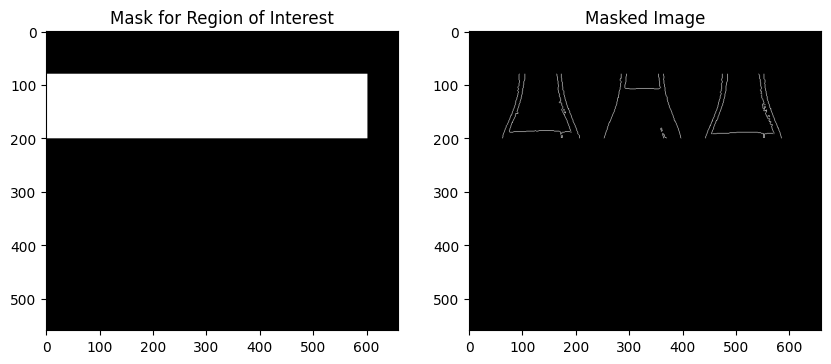

In [9]:
# vertices for mask points arranged clockwise
l1 = [0,200]
l2 = [0,80]
r1 = [600,80]
r2 = [600,200]

# Define array of numpy points
vertices = np.array([[l1,l2,r1,r2 ]], dtype=np.int32)

# Call mask function
mask,masked_image = mask_img(canny_edges,vertices)

# Plot mask and masked image
f, axarr = plt.subplots(1,2,figsize=(10,6))
axarr[0].imshow(mask,'gray')
axarr[0].title.set_text('Mask for Region of Interest')
axarr[1].imshow((masked_image),'gray')
axarr[1].title.set_text('Masked Image')

## 4. Hough Transform

The Hough Transform is used to convert points to lines in the image.
*   [Hough Algorithm](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html) (example of use)

In [10]:
def apply_hough_transform(image_edges, rho=1, theta=np.pi/180, threshold=30, min_line_len=20, max_line_gap=20):
    """
    Applies Hough Transform to detect lines in an image.

    Args:
        image_edges (numpy.ndarray): Binary image with edges (e.g., obtained from Canny edge detection).
        rho (float): Distance resolution of the accumulator in pixels.
        theta (float): Angle resolution of the accumulator in radians.
        threshold (int): Minimum number of votes (threshold) to consider a line.
        min_line_len (int): Minimum length of a line segment to be considered.
        max_line_gap (int): Maximum gap between line segments to be connected into a single line.

    Returns:
        numpy.ndarray: Array of lines in (x1, y1, x2, y2) format.
    """
    # Use HoughLinesP function which considers gaps and minimum line length
    lines = cv2.HoughLinesP(image_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines


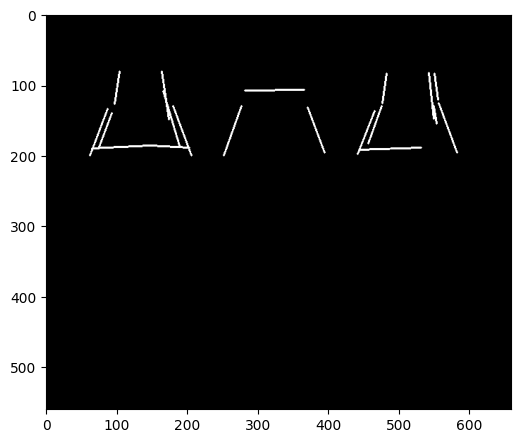

In [11]:
# Call Hough Transform
lines = apply_hough_transform(masked_image)

# Plot resuling lines using cv2.lines
lines_image = np.uint8(np.zeros(np.shape(masked_image)))
f, axarr = plt.subplots(1,1,figsize=(6,6))

for line in lines:
   x1,y1,x2,y2 = line[0]
   cv2.line(lines_image,(x1,y1),(x2,y2),(255,0,0),2)

axarr.imshow(lines_image,'gray')


## 5. Find horizontal lines corresponding to fluid levels

We have detected horizontal lines corresponding to the fluid but also many vertical lines corresponding to the bottle edges.
We can simply remove distracting vertical edges by just finding horizonal lines which have small slopes m close to 0.
Complete the function find_horizontal_lines which returns only the horizontal lines from the set of lines produced by the Hough Transform in the previous step.
* Take care when computing slopes that the slope could return nan if the lines is vertical.You can modify you code to take of these exceptions.

In [18]:
def select_horizontal_lines(lines, slope_threshold=0.1):
    """
    Selects horizontal lines from a set of lines based on their slopes.

    Args:
        lines (list of tuples): List of lines, where each line is represented as a tuple (x1, y1, x2, y2).
        slope_threshold (float): Threshold for slope to consider a line as horizontal.

    Returns:
        horizontal_lines: A list of horizontal lines.
    """
    horizontal_lines = []

    for line in lines:
        # Access the first and only row of the numpy array and unpack the values.
        x1, y1, x2, y2 = line[0]
        # Avoid division by zero when x1 == x2 (vertical line)
        if x1 != x2:
            slope = abs((y2 - y1) / (x2 - x1))
        else:
            slope = float('inf')  # Treat vertical line as having an infinite slope

        # Check if the slope is within the threshold for horizontal lines
        if slope <= slope_threshold:
            horizontal_lines.append(line)

    return horizontal_lines

Call Function & Display Images on the original colour image.

[array([[ 65, 190, 147, 186]], dtype=int32), array([[444, 192, 532, 189]], dtype=int32), array([[282, 108, 366, 107]], dtype=int32), array([[148, 186, 203, 189]], dtype=int32)]


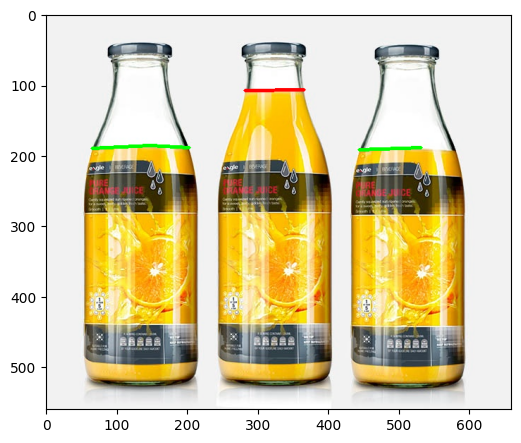

In [20]:
slope_threshold = 0.2

# Call function
horizontal_lines = select_horizontal_lines(lines, slope_threshold=slope_threshold)
print(horizontal_lines)

# Create plot
f, axarr = plt.subplots(1,1,figsize=(6,6))
x_step =130


for line in horizontal_lines:
   x1,y1,x2,y2 = line[0] # Access the first row of the line array
   y_average = (y2+y1)/2

   blk = np.zeros(image.shape, np.uint8)
   if y_average<150:
      cv2.line(image,(x1,y1),(x2,y2),(255,0,0),3)
   else:
      cv2.line(image,(x1,y1),(x2,y2),(0,255,0),3)
axarr.imshow(image)